# F-B method

In [1]:
import numpy as np
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel
from astroquery.ned import Ned
import astropy.units as u
import pylab as plt
from scipy import interpolate
from matplotlib.colors import ListedColormap
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from IPython.display import clear_output
from pyBBarolo import *
from scipy.optimize import curve_fit
from scipy import stats
mpl.style.use('classic')

#### Pre-requisite operation (fill Nans)

In [2]:
# Filling NaN pixels with the values of pixels located symmetrically relative to the major axis.
# It is a necessary procedure if we want to obtain reliable results from the Barolo application.

def fill_nans(fits_file=None,galname=None,cvel=None,savefits=False,show_plot=False):
    
    RA = Ned.query_object(galname)['RA']
    DEC = Ned.query_object(galname)['DEC']
    cposition = SkyCoord('{} {}'.format(RA[0],DEC[0]), frame='fk5', unit='deg', equinox='J2000.0')
    data =  WCS(fits_file, naxis = 2)
    y0_,x0_ = skycoord_to_pixel(cposition,data) #find central pixel
    y0_,x0_ = int(y0_),int(x0_)
    
    maps = fits.getdata(fits_file)
    maps_ = np.squeeze(maps)
    maps = maps_-cvel
    maps = maps.T
    X,Y = np.meshgrid(np.arange(0,maps.shape[1], 1), np.arange(0,maps.shape[0], 1))

    R_max = np.min([x0_,maps.shape[1]-x0_,y0_,maps.shape[0]-y0_])
    nan_map = np.isnan(maps) & (np.abs(X-x0_) < R_max) &  (np.abs(Y-y0_) < R_max)

    nan_X = X[nan_map]
    nan_Y = Y[nan_map]

    maps_new = maps*1.0
    maps_new[nan_Y, nan_X] = - maps[2*y0_-nan_Y,2*x0_-nan_X]

    if show_plot:
        fig = plt.figure(figsize=[21,9])
        plt.subplots_adjust(wspace=0.1, hspace=0.2)
        X, Y = np.meshgrid(np.arange(0, maps.shape[1], 1), np.arange(0, maps.shape[0], 1))    

        plt.subplot(1,2,1) 
        plt.title(r'$V_{obs}$', fontsize=35, pad=20)
        quadmesh = plt.pcolormesh(X,Y, maps, cmap='coolwarm')
        quadmesh.set_clim(vmin=-150,vmax=150)
        plt.tick_params(bottom=False,labelbottom=False,left=False,labelleft=False)
        plt.colorbar()

        plt.subplot(1,2,2) 
        plt.title(r'$V_{obs}$ fill Nan', fontsize=35, pad=20)
        quadmesh = plt.pcolormesh(X,Y, maps_new, cmap='coolwarm')
        quadmesh.set_clim(vmin=-150,vmax=150)
        plt.tick_params(bottom=False,labelbottom=False,left=False,labelleft=False)
        plt.colorbar()
    
    if savefits:
        
        data = fits.open(fits_file)
        header = data[0].header
        fits_new = fits.PrimaryHDU(data=np.array(maps_new.T+cvel),header=header)
        fits_new.writeto(fits_file.replace('.fits','_notnan.fits'),overwrite=True)
    

In [3]:
fill_nans(fits_file='./kinematics/NGC4321_RV.fits',galname='NGC4321',cvel=1560,savefits=True)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


### Functions for obtaining residual velocities and applying the F-B method.

In [2]:
# create a colormap for residial velocities
palette = ListedColormap(['#2b3cce','#4c5fdd','#6b80e8','#8ca0f2','#b0c1f9','#d6e1ff','#ffd8ca','#f1b6a1','#e2957b','#d07356','#bd5133','#a82a11'])

In [3]:
def obtain_residuals(fits_file=None,galname=None,step=None,width=None,dmin=None,dmax=None,cvel=None,PA0=None,incl0=None,
                    vmax=None,free_param=None,side=None,show_plot=False,get_residuals=False, get_velcurve=False, show_profiles=False, save_fig=False):
    ''' fits_file --- path to fits file;
        step --- step between adjacent rings;
        width --- width of the ring (optionaly width is several times greater than step in order to odtain smooth velocity field model)
        dmin, dmax --- minimum and maximum radius of the rings
        cvel --- systematic velocity of a galaxy (if None, it will be taken from Ned)
        PA0 --- zero approximation of positional angle
        incl0 --- zero approximation of inclination
        vmax --- zero approximation for plato velocity
        free_param --- what parameters vary for each ring ('PA VROT INC')
        side -- which side (approching (A), residing(R) or both(B)) uses to find a reliable parameter
        show_plot --- if True show figures of observable, model and residual velocity
        get_residuals --- if True obtain array of residual velocities
        get_velcurve --- if True obtain array of azimuthal velocity
        show_profiles --- if True show figures of PA and Vrot profiles
        save_fig --- if True save figures of velocities        
    '''    
    
    if cvel is None:
        cvel = Ned.query_object(galname)['Velocity'][0]
        
    RA = Ned.query_object(galname)['RA']
    DEC = Ned.query_object(galname)['DEC']
    cposition = SkyCoord('{} {}'.format(RA[0],DEC[0]), frame='fk5', unit='deg', equinox='J2000.0')
    data =  WCS(fits_file, naxis = 2)
    y0_,x0_ = skycoord_to_pixel(cposition,data) #find central pixel

    if galname=='NGC3686':
        shiftdeg = pixel_to_skycoord(y0_-1,x0_,data)
    else:    
        shiftdeg = pixel_to_skycoord(y0_,x0_-1.,data)
    resol = abs(shiftdeg.dec.arcsec-cposition.dec.arcsec) #find pixel size
    print()
    #get profiles of vrot, PA and incl
    rad = []
    v_rot = []
    pa = []
    inc = []
    
    if side is None:
        side='B'
    
    for i in range(int(width/step)):
    
        rm = FitMod2D(fits_file.replace('.fits','_notnan.fits'))
        rm.init(radii=np.arange(dmin + i*step,dmax + i*step,width),xpos=int(y0_),ypos=int(x0_),vsys=cvel,vrad=15,vrot=vmax,inc=incl0,phi=PA0)
        rm.set_options(wfunc=2, free=free_param, mask='SMOOTH&SEARCH',side=side)
        rings = rm.compute(threads=2)
        rad = np.concatenate((rad,rings['rad']))
        v_rot = np.concatenate((v_rot,rings['vrot']))
        pa = np.concatenate((pa,rings['phi']))
        inc = np.concatenate((inc,rings['inc']))
        
    clear_output(wait=True)
    array = zip(rad,v_rot,pa, inc)
    array_sort = sorted(array, key=lambda tup: tup[0],reverse=True)
    rad = [x[0] for x in array_sort]
    v_rot = [x[1] for x in array_sort]
    pa = [x[2] for x in array_sort]
    inc = [x[3] for x in array_sort] 
    # print(rings['vsys'])
    # print(resol)
    if show_profiles:
        plt.plot(rad,pa,'o')
        plt.plot(rad,v_rot,'o')
    
    #obtain maps of residuals and distances
    
    vel_map_ = fits.getdata(fits_file, naxis = 2)
    vel_map = np.squeeze(vel_map_)
    x0 = x0_
    y0 = y0_

    residuals_map = np.empty(vel_map.shape)
    residuals_map[:] = np.nan
    vel_obs = np.empty(vel_map.shape)
    vel_obs[:] = np.nan
    model_vel_map = np.empty(vel_map.shape)
    model_vel_map[:] = np.nan
    distance_map = np.empty(vel_map.shape)
    distance_map[:] = np.nan
    mask_prev = np.empty(vel_map.shape)
    mask_prev[:] = np.nan

    width_next=step*1.5
    for ind,dist in enumerate(rad):

        PA_res = pa[ind]
        sini = np.sin(inc[ind]*np.pi/180.)
        cosi = np.cos(inc[ind]*np.pi/180.)
        vel_res = v_rot[ind]

        PA_res_ = -PA_res*np.pi/180.

        X,Y = np.meshgrid(np.arange(0,vel_map.shape[1], 1), np.arange(0,vel_map.shape[0], 1))
        # create deprojected grid
        X_shift = X - y0
        Y_shift = Y - x0    
        X_rot = Y_shift * np.cos(PA_res_) + X_shift * np.sin(PA_res_)
        Y_rot0 =  -Y_shift * np.sin(PA_res_) + X_shift * np.cos(PA_res_)
        Y_rot = Y_rot0/cosi

        #cut ring
        R = np.sqrt(X_rot**2 + Y_rot**2)
        mask_ = (R>(dist-width_next/2)/resol) & (R<(dist+width_next)/resol)
        mask_new = np.where(mask_, mask_, np.nan)

        mask_2notnan = ~np.isnan(mask_new) & np.isnan(mask_prev)
        mask_notnan = ~np.isnan(mask_new) & ~np.isnan(mask_prev)

        # fill distance array
        distance_map[mask_2notnan] = R[mask_2notnan]
        distance_map[mask_notnan]  = (distance_map[mask_notnan] + R[mask_notnan])/2
        mask_prev[mask_] = True

        Phi = np.arctan2(Y_rot,X_rot)
        # fill velocity arrays
        V_model = vel_res * np.cos(Phi) 
        V_obs = (vel_map-cvel)/sini 
        residuals  = V_obs-V_model  

        model_vel_map[mask_2notnan] = V_model[mask_2notnan]
        model_vel_map[mask_notnan]  = (model_vel_map[mask_notnan] + V_model[mask_notnan])/2

        vel_obs[mask_2notnan] = V_obs[mask_2notnan]
        vel_obs[mask_notnan]  = (vel_obs[mask_notnan] + V_obs[mask_notnan])/2

        residuals_map[mask_2notnan] = residuals[mask_2notnan]
        residuals_map[mask_notnan]  = residuals[mask_notnan]
        
    if show_plot:
        
        fig = plt.figure(figsize=[31,8.4])
        plt.subplots_adjust(wspace=0.05, hspace=0.1)
        X, Y = np.meshgrid(np.arange(0, vel_map.shape[1], 1), np.arange(0, vel_map.shape[0], 1))    


        plt.subplot(1,3,1) 
        plt.title(r'$V_{obs}$', fontsize=50, pad=20)
        quadmesh = plt.pcolormesh(X,Y, vel_obs, cmap='coolwarm')
        quadmesh.set_clim(vmin=-vmax,vmax=vmax)
        plt.xlim(y0-dmax/resol,y0+dmax/resol)
        plt.ylim(x0-dmax/resol,x0+dmax/resol)
        plt.tick_params(bottom=False,labelbottom=False,left=False,labelleft=False,right=False,labelright=False,top=False,labeltop=False)
        plt.colorbar().ax.tick_params(labelsize=27)

        plt.subplot(1,3,2) 
        plt.title(r'$V_{model}$', fontsize=50, pad=20)
        quadmesh = plt.pcolormesh(X,Y,model_vel_map, cmap='coolwarm')
        quadmesh.set_clim(vmin=-vmax,vmax=vmax)
        plt.xlim(y0-dmax/resol,y0+dmax/resol)
        plt.ylim(x0-dmax/resol,x0+dmax/resol)
        plt.tick_params(bottom=False,labelbottom=False,left=False,labelleft=False,right=False,labelright=False,top=False,labeltop=False)
        plt.colorbar().ax.tick_params(labelsize=27)

        plt.subplot(1,3,3) 
        plt.title(r'$V_{obs} - V_{model}$', fontsize=50, pad=20)
        quadmesh = plt.pcolormesh(X,Y,residuals_map, cmap=palette)
        quadmesh.set_clim(vmin=-40,vmax=40)        
        plt.ylim(x0-dmax/resol,x0+dmax/resol)
        plt.xlim(y0-dmax/resol,y0+dmax/resol)
        plt.tick_params(bottom=False,labelbottom=False,left=False,labelleft=False,right=False,labelright=False,top=False,labeltop=False)
        plt.colorbar().ax.tick_params(labelsize=27)
        
        if save_fig:
            plt.savefig('./maps_images/'+galname+'_vel_maps.png',transparent = False, dpi=300, bbox_inches='tight', pad_inches=0.05, facecolor='white')
        
    if get_residuals:
        return residuals_map, distance_map
    if get_velcurve:
        return rad,v_rot

In [4]:
def histogram(dist,width,dist_lim):
    
    border = np.arange(1.,dist_lim+width,width)
    
    dist_sort = sorted(dist)
    
    rel_count=[]
    centers=[]
    for i in range(len(border)-1):
        count = 0
        for r in dist_sort:
            
            if (r<border[i+1]) and (r>=border[i]):
                
                count+=1
        
        rel_count.append(count)
        centers.append((border[i+1]+border[i])/2)
        
    return centers,rel_count

def FB_method(fits_file=None,galname=None,step=None,width=None,dmin=None,dmax=None,cvel=None,PA0=None,incl0=None,
                    vmax=None,free_param=None,side=None,width_hist=None,delta_V=None,plot_hist=False,get_values=False,plot_velocity=False):
    '''fits_file --- path to fits file;
        step --- step between adjacent rings (arcsec);
        width --- width of the ring (optionaly width is several times greater than step in order to obtain smooth velocity field model)
        dmin, dmax --- minimum and maximum radius of the rings (arcsec)
        cvel --- systematic velocity of a galaxy (if None, it will be taken from Ned)
        PA0 --- zero approximation of positional angle
        incl0 --- zero approximation of inclination
        vmax --- zero approximation for plato velocity
        free_param --- what parameters vary for each ring ('PA VROT INC')
        side -- which side (approching (A), residing(R) or both(B)) uses to find a reliable parameter
        width_hist --- width of eanh din on histogram (arcsec)
        delta_V --- precision of observational velocity
        plot_hist --- if True plot the histogram from F-B method
        get_values --- if True obtain the values from histogram        
    '''
    
    residuals_vel, distance = obtain_residuals(fits_file=fits_file,galname=galname,step=step,width=width,dmin=dmin,dmax=dmax,
                    cvel=cvel,PA0=PA0,incl0=incl0,vmax=vmax,free_param=free_param,side=side,get_residuals=True,show_plot=plot_velocity)
    
    dist_change_sign=[]
    
    for j in range(1,len(residuals_vel[0])-1):
        for i in range(1,len(residuals_vel)-1):
                                
            if (np.abs(residuals_vel[i][j]) > 0) & (distance[i][j]<dmax):              
                
                index = [[m,l] for l in range(j-1,j+2) for m in range(i-1,i+2)]          
                dist_arcsec = [distance[m,l] for l in range(j-1,j+2) for m in range(i-1,i+2)]
                
                array = zip(dist_arcsec,index)
                array_sort = sorted(array, key=lambda tup: tup[0],reverse=True)
                index_sort = [x[1] for x in array_sort]
                   
                vel_prev = residuals_vel[index_sort[0][0]][index_sort[0][1]]
                vel_next = residuals_vel[index_sort[-1][0]][index_sort[-1][1]]
                    
                
                if (abs(vel_prev)>delta_V) and (abs(vel_next)>delta_V) and (vel_prev*vel_next<0.) and (abs(vel_prev-vel_next)<50):

                    dist_change_sign.append(distance[i][j])            


    r, N = histogram(dist_change_sign,width_hist,dmax)
    
    if plot_hist:
        
        fig = plt.figure(figsize=[15,4])
        
        plt.bar(r,N,width=width_hist,color='silver')

        plt.ylabel('$N$', fontsize=30)
        plt.xlim(-1,dmax+3)
        plt.ylim(0,max(N)+5)
        plt.grid()
        
        plt.xlabel('$R$, arcsec', fontsize=30)
        plt.tick_params(axis='both', which='major', labelsize=22)
    
    if get_values:
        return r, N 

    
# Monte-Carlo realization of F-B method with different parameters, fixation of main peaks on histogram for each realization   
def FB_MonteCarlo_peaks(fits_file=None,galname=None,step=None,width=None,width_err=None,ratio=None,dmin=None,dmax=None,cvel=None,cvel_err=None,
                  PA0=None, PA_err=None, incl0=None,incl_err=None,vmax=None,free_param=None,side=None,width_hist=None,delta_V=None,N_iter=None,get_results=False):
    '''fits_file --- path to fits file;
        step --- step between adjacent rings (arcsec);
        width --- width of the ring (optionaly width is several times greater than step in order to obtain smooth velocity field model)
        dmin, dmax --- minimum and maximum radius of the rings (arcsec)
        cvel --- systematic velocity of a galaxy (if None, it will be taken from Ned)
        PA0 --- zero approximation of positional angle
        incl0 --- zero approximation of inclination
        vmax --- zero approximation for plato velocity
        free_param --- what parameters vary for each ring ('PA VROT INC')
        side -- which side (approching (A), residing(R) or both(B)) uses to find a reliable parameter
        width_hist --- width of eanh din on histogram (arcsec)
        delta_V --- precision of observational velocity
        N_iter --- the number of iterations       
    '''
    width_vary = np.random.normal(width, width_err, N_iter)
    vsys_vary = np.random.normal(cvel, cvel_err, N_iter)
    incl_vary = np.random.normal(incl0,incl_err, N_iter)
    if PA_err is not None:
        pa_vary = np.random.normal(PA0,PA_err, N_iter)
    else:
        pa_vary = np.zeros(N_iter)
        pa_vary[:] = PA0
        
    dist_on_peak = []
    dist_on_peak1 = []
    dist_on_peak2 = []
    dist_on_peak3 = []
    
    for ind in range(N_iter):
        if ind%10==0:
            print('iteration: '+str(ind))
        if ratio is None:
            ratio = 5
        step_vary = int(width_vary[ind]/ratio)+1

        dist, hist = FB_method(fits_file=fits_file,galname=galname,step=step_vary,width=width_vary[ind],dmin=dmin,dmax=dmax,cvel=vsys_vary[ind],
                        PA0=pa_vary[ind],incl0=incl_vary[ind],vmax=vmax,free_param=free_param,side=side,width_hist=width_hist,delta_V=delta_V,get_values=True)
        
                
        array = zip(hist,dist)
        array_sort = sorted(array, key=lambda tup: tup[0],reverse=True)
        hist_sort = [x[0] for x in array_sort]
        dist_sort = [x[1] for x in array_sort]
        
        
        if hist_sort[0]!=0:
    
            dist_on_peak.append(dist_sort[0])
            if hist_sort[0]==hist_sort[1]:
                dist_on_peak.append(dist_sort[1])
            else:
                dist_on_peak1.append(dist_sort[1]) 

            if hist_sort[1]==hist_sort[2]:
                dist_on_peak1.append(dist_sort[2]) 
            else:
                dist_on_peak2.append(dist_sort[2])

            if hist_sort[2]==hist_sort[3]:
                dist_on_peak2.append(dist_sort[3]) 
            else:
                dist_on_peak3.append(dist_sort[3])    

            if hist_sort[3]==hist_sort[4]:
                dist_on_peak3.append(dist_sort[4]) 

    fig = plt.figure(figsize=[15,15])
    plt.subplots_adjust(wspace=0.05, hspace=0.1)
    
    ylim=[0,N_iter/2]
    gs = GridSpec(4, 5, figure=fig) 
    #######
    ax = fig.add_subplot(gs[0, 0:]) 
    ax.set_xticks([])

    ax.hist(dist_on_peak, bins=int(dmax/width_hist),color='silver' )
    #ax.boxplot(dist_on_peak,0, 'rs', 0)
    ax.text(0, ylim[1]-5, r'Main peak', fontsize=22, va='top')
    ax.set_ylabel('$N$', fontsize=30)
    ax.set_xlim(-1,dmax)
    ax.set_ylim(ylim[0],ylim[1])
    plt.tick_params(axis='both', which='major', labelsize=18)

    def to_new_axis(x):
        return x

    def from_new_axis(x):
        return x
    secax = ax.secondary_xaxis('top', functions=(to_new_axis, from_new_axis))
    secax.tick_params(axis='both', which='major', labelsize=22)
    ax.grid(False)

    ax = fig.add_subplot(gs[1, 0:]) 
    ax.set_xticks([])

    ax.hist(dist_on_peak1, bins=int(dmax/width_hist),color='silver' )
    #ax.boxplot(dist_on_peak1, 'rs',  positions=-10)
    ax.text(0, ylim[1]-5, r'1st local peak', fontsize=22, va='top')
    ax.set_ylabel('$N$', fontsize=30)
    ax.set_xlim(-1,dmax)
    ax.set_ylim(ylim[0],ylim[1])
    plt.tick_params(axis='both', which='major', labelsize=18)
    ax.grid(False)

    ax = fig.add_subplot(gs[2, 0:]) 
    ax.set_xticks([])

    ax.hist(dist_on_peak2, bins=int(dmax/width_hist),color='silver' )
    #ax.boxplot(dist_on_peak2, 'rs',  positions=-10)
    ax.text(0, ylim[1]-5, r'2nd local peak', fontsize=22, va='top')
    ax.set_ylabel('$N$', fontsize=30)
    ax.set_xlim(-1,dmax)
    ax.set_ylim(ylim[0],ylim[1])
    plt.tick_params(axis='both', which='major', labelsize=18)
    ax.grid(False)

    ax = fig.add_subplot(gs[3, 0:]) 
    #ax.set_xticks([])

    ax.hist(dist_on_peak3, bins=int(dmax/width_hist),color='silver' )
    #ax.boxplot(dist_on_peak3, 'rs',  positions=-10)
    ax.text(0, ylim[1]-5, r'3d local peak', fontsize=22, va='top')
    ax.set_ylabel('$N$', fontsize=30)
    ax.set_xlim(-1,dmax)
    ax.set_ylim(ylim[0],ylim[1])
    ax.grid(False)

    plt.xlabel('$R, arcsec$', fontsize=30)
    plt.tick_params(axis='both', which='major', labelsize=18)
       
    if get_results:
        return dist_sort, dist_on_peak, dist_on_peak1, dist_on_peak2, dist_on_peak3    

    
# Monte-Carlo realization of F-B method with different parameters,adding up the histogram values of all realization       
def FB_MonteCarlo_sum(fits_file=None,galname=None,step=None,width=None,width_err=None,ratio=None,dmin=None,dmax=None,cvel=None,cvel_err=None,
                  PA0=None, PA_err=None, incl0=None,incl_err=None,vmax=None,free_param=None,side=None,width_hist=None,delta_V=None,N_iter=None, get_results=False):
    '''fits_file --- path to fits file;
        step --- step between adjacent rings (arcsec);
        width --- width of the ring (optionaly width is several times greater than step in order to obtain smooth velocity field model)
        dmin, dmax --- minimum and maximum radius of the rings (arcsec)
        cvel --- systematic velocity of a galaxy (if None, it will be taken from Ned)
        PA0 --- zero approximation of positional angle
        incl0 --- zero approximation of inclination
        vmax --- zero approximation for plato velocity
        free_param --- what parameters vary for each ring ('PA VROT INC')
        side -- which side (approching (A), residing(R) or both(B)) uses to find a reliable parameter
        width_hist --- width of eanh din on histogram (arcsec)
        delta_V --- precision of observational velocity
        N_iter --- the number of iterations'''
    
    width_vary = np.random.normal(width, width_err, N_iter)
    vsys_vary = np.random.normal(cvel, cvel_err, N_iter)
    incl_vary = np.random.normal(incl0,incl_err, N_iter)
    if PA_err is not None:
        pa_vary = np.random.normal(PA0,PA_err, N_iter)
    else:
        pa_vary = np.zeros(N_iter)
        pa_vary[:] = PA0
        
    dist, hist_sum = FB_method(fits_file=fits_file,galname=galname,step=step,width=width,dmin=dmin,dmax=dmax,cvel=cvel,
                        PA0=PA0,incl0=incl0,vmax=vmax,free_param=free_param,side=side,width_hist=width_hist,delta_V=delta_V,get_values=True)
    
    
    for ind in range(N_iter):
        if ind%10==0:
            print('iteration: '+str(ind))
        if ratio is None:
            ratio = 5
        step_vary = int(width_vary[ind]/ratio)+1

        dist, hist = FB_method(fits_file=fits_file,galname=galname,step=step_vary,width=width_vary[ind],dmin=dmin,dmax=dmax,cvel=vsys_vary[ind],
                        PA0=pa_vary[ind],incl0=incl_vary[ind],vmax=vmax,free_param=free_param,side=side,width_hist=width_hist,delta_V=delta_V,get_values=True)
        
        hist_sum = np.array(hist_sum) + np.array(hist)        


    fig = plt.figure(figsize=[15,6])
    plt.subplots_adjust(wspace=0.05, hspace=0.1)
    
    gs = GridSpec(1, 5, figure=fig) 
    #######
    plt.bar(dist,hist_sum/N_iter,width=width_hist,color='silver')

    plt.ylabel('$N$', fontsize=30)
    plt.xlim(-1,dmax+3)
    plt.ylim(0,max(hist_sum)/N_iter+5)
    plt.grid()

    plt.tick_params(axis='both', which='major', labelsize=18)
       
    if get_results:
        return dist, hist_sum    
    
    

In [5]:
# fit multiple Gauss functions
def assymGauss(x, a, x0, s11, s12):
    test = x<=x0
    P = np.where(test, a*np.exp(-((x-x0)/s11)**2), a*np.exp(-((x-x0)/s12)**2))
    return P

def Gauss(x, a, x0, s):
    return a*np.exp(-((x-x0)/s)**2)

def DoubleGauss(x, a1, x01, s1, a2, x02, s2):
    return Gauss(x, a1, x01, s1) + Gauss(x, a2, x02, s2)

def DoubleGauss(x, a1, x01, s1, a2, x02, s2):
    return Gauss(x, a1, x01, s1) + Gauss(x, a2, x02, s2)

def TripleGauss(x, a1, x01, s1, a2, x02, s2, a3, x03, s3):
    return Gauss(x, a1, x01, s1) + Gauss(x, a2, x02, s2) + Gauss(x, a3, x03, s3)

def QuadrupleGauss(x, a1, x01, s1, a2, x02, s2, a3, x03, s3, a4, x04, s4):
    return Gauss(x, a1, x01, s1) + Gauss(x, a2, x02, s2) + Gauss(x, a3, x03, s3) + Gauss(x, a4, x04, s4)

def FitGauss(X,Y,num_Gauss=None,init_approx=None,bounds=None, assym=False):
    
    if num_Gauss==1:
        if assym:
            p, cov = curve_fit(assymGauss, X, Y, p0=init_approx, bounds=bounds)
        else:
            p, cov = curve_fit(Gauss, X, Y, p0=init_approx, bounds=bounds)
        
    elif num_Gauss==2:
        p, cov = curve_fit(DoubleGauss, X, Y, p0=init_approx, bounds=bounds)
        
    elif num_Gauss==3:
        p, cov = curve_fit(TripleGauss, X, Y, p0=init_approx, bounds=bounds)
        
    elif num_Gauss==4:
        p, cov = curve_fit(QuadrupleGauss, X, Y, p0=init_approx, bounds=bounds)
        
    return p    


### NGC2403

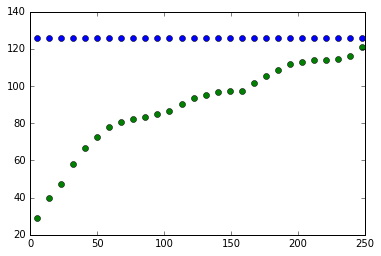

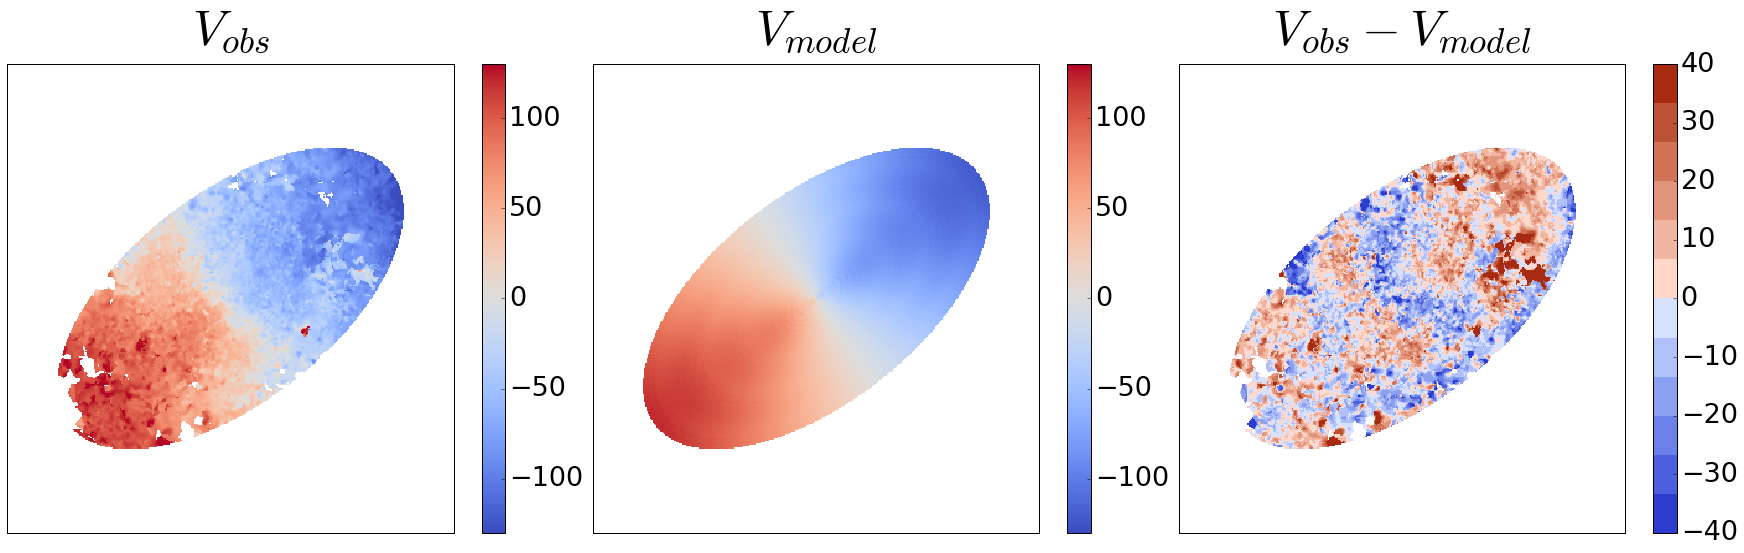

In [108]:
obtain_residuals(fits_file='./kinematics/NGC2403_RV.fits',galname='NGC2403',step=9,width=36,dmin=5,dmax=290,cvel=143,PA0=126,incl0=60,
                    vmax=130,free_param='VROT',side='R',show_plot=True,get_residuals=False, get_velcurve=False,show_profiles=True,save_fig=True)

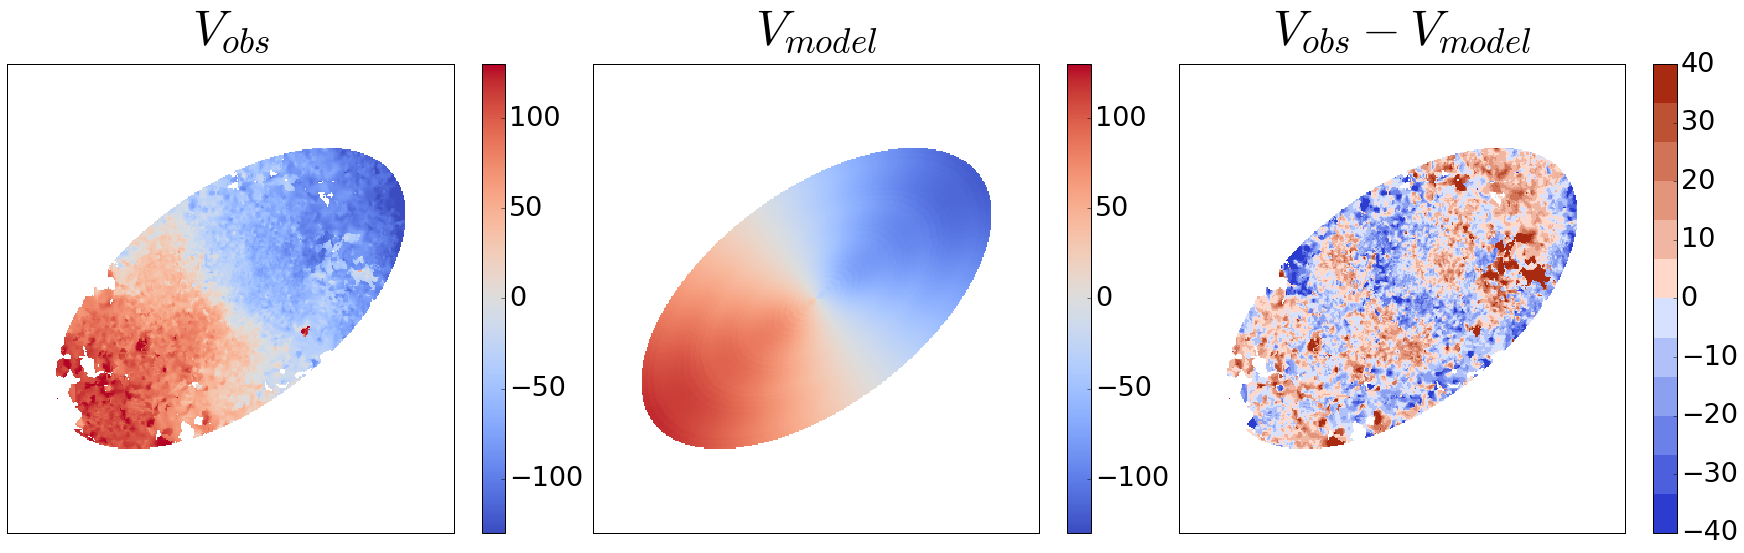

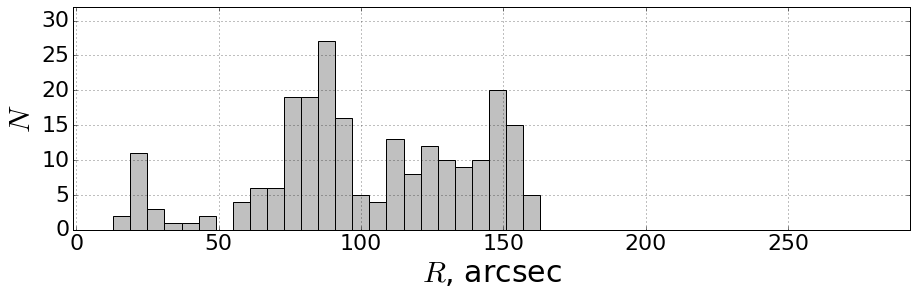

In [9]:
FB_method(fits_file='./kinematics/NGC2403_RV.fits',galname='NGC2403',step=9,width=36,dmin=5,dmax=290,cvel=144,PA0=125,incl0=59,
                    vmax=130,free_param='VROT',side='R',width_hist=6,delta_V=14,plot_hist=True,get_values=False,plot_velocity=True)

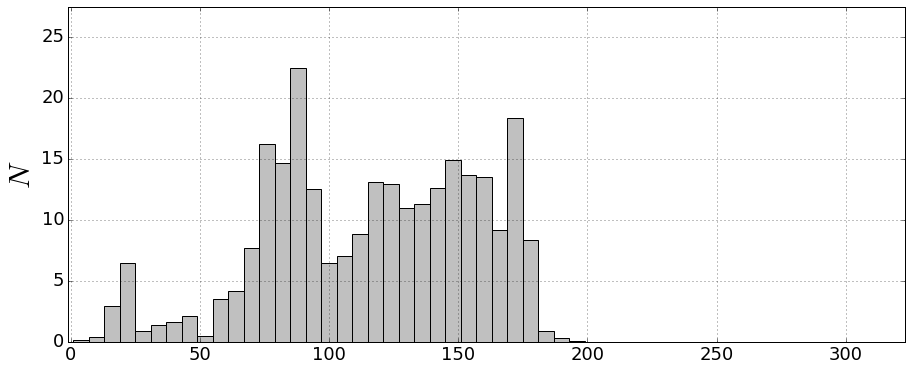

In [6]:
dist_2403,hist_2403 = FB_MonteCarlo_sum(fits_file='./kinematics/NGC2403_RV.fits',galname='NGC2403',step=8,width=35,width_err=2,ratio=5,dmin=5,
              dmax=320,cvel=143,cvel_err=2,PA0=125,PA_err=1,incl0=59,incl_err=1,vmax=130,free_param='VROT',side='R',width_hist=6,delta_V=14,N_iter=600,get_results=True)

In [7]:
np.save('./results_images/NGC2403_MC_dist.npy',dist_2403)
np.save('./results_images/NGC2403_MC_hist.npy',hist_2403)

85.15715551821015 12.666910729431807
150.77985991979142 29.999999999999996 19.999999999999996


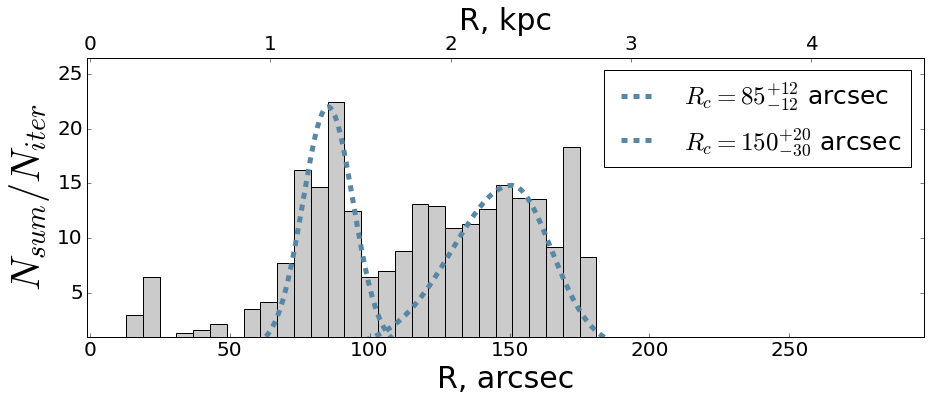

In [16]:
dist_2403=np.load('./results_images/NGC2403_MC_dist.npy')
hist_2403=np.load('./results_images/NGC2403_MC_hist.npy')
N_iter=600
width_hist=6
cont=2
Mpc=3.2
dist_points = np.linspace(dist_2403[0],dist_2403[-1],400)

fig = plt.figure(figsize=[15,5])
plt.subplots_adjust(wspace=0.05, hspace=0.1)

gs = GridSpec(1, 6, figure=fig) 
ax = fig.add_subplot(gs[0, 0:]) 

ax.bar(dist_2403,hist_2403/N_iter,width=width_hist,color='#cbcbcb')

params2 = FitGauss(dist_2403, hist_2403/N_iter-cont, num_Gauss=1, init_approx=[23,80,8], bounds=[[22,70,1],[25,90,15]],assym=False)
F_Gauss = Gauss(dist_points,params2[0],params2[1],params2[2])
ax.plot(dist_points,F_Gauss,'--',linewidth=5,color='#5886a5',label=r'$R_c = 85^{+12}_{-12}$ arcsec')
print(params2[1],params2[2])

params1 = FitGauss(dist_2403, hist_2403/N_iter-cont, num_Gauss=1, init_approx=[18,160,10,10], bounds=[[14,140,5,5],[20,170,30,20]],assym=True)
F_Gauss = assymGauss(dist_points,params1[0],params1[1],params1[2],params1[3])
ax.plot(dist_points,F_Gauss,'--',linewidth=5,color='#5886a5',label=r'$R_c = 150^{+20}_{-30}$ arcsec')
print(params1[1],params1[2],params1[3])

ax.legend(fontsize=25,loc='upper right')
def to_new_axis(x):
    scale = np.pi / (180 * 3600) * Mpc * 10**3
    return x*scale
        
def from_new_axis(x):
    scale = np.pi / (180 * 3600) * Mpc * 10**3
    return x/scale
secax = ax.secondary_xaxis('top', functions=(to_new_axis, from_new_axis))
secax.tick_params(axis='both', which='major', labelsize=20)

plt.ylabel(r'$N_{sum}/N_{iter}$', fontsize=40)
plt.xlim(-1,dist_2403[-5])
plt.ylim(1,max(hist_2403)/N_iter+4)
plt.xlabel('R, arcsec', fontsize=30)
secax.set_xlabel('R, kpc', fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=20,top=False,labeltop=False)
plt.savefig('./results_images/NGC2403_F-B.png',transparent = False, dpi=300, bbox_inches='tight', pad_inches=0.05, facecolor='white')

### NGC3686

[1153. 1153. 1153. 1153. 1153. 1153. 1153. 1153. 1153.]
1.077042719036399


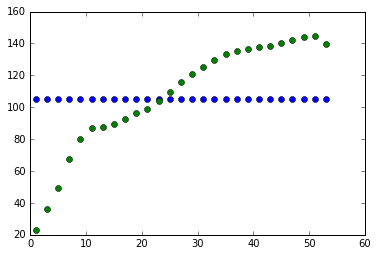

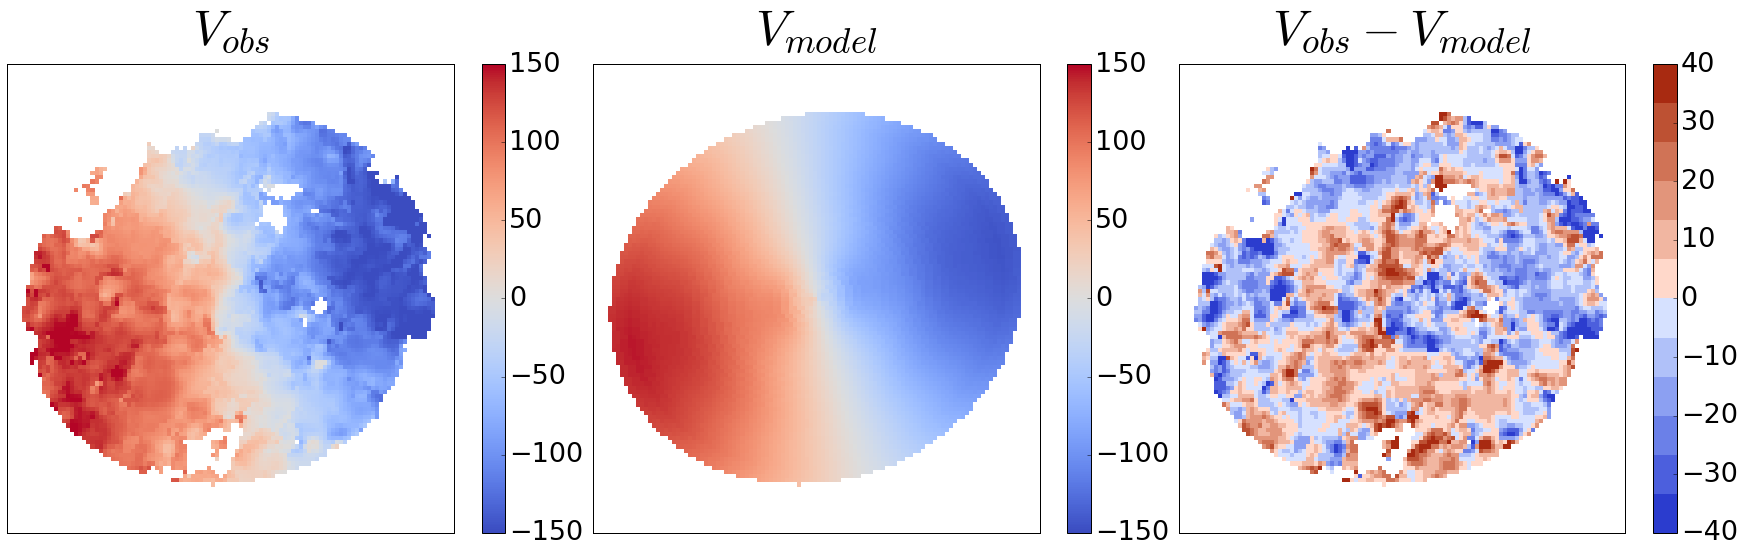

In [32]:
obtain_residuals(fits_file='./kinematics/NGC3686_RV.fits',galname='NGC3686',step=2,width=6,dmin=1,dmax=60,cvel=1153,PA0=105,incl0=33,
                    vmax=150,free_param='VROT',side='B',show_plot=True,get_residuals=False, get_velcurve=False,show_profiles=True,save_fig=True)

[1153. 1153. 1153. 1153. 1153. 1153. 1153.]
1.077042719036399


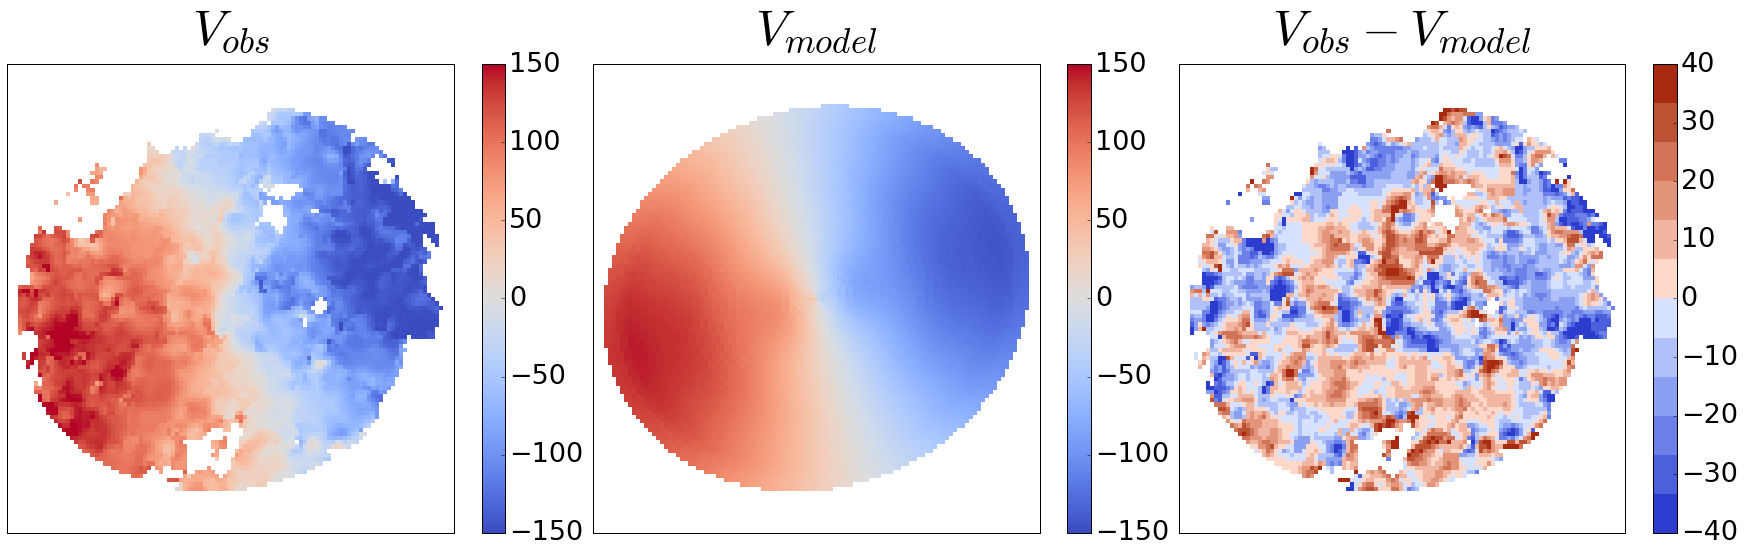

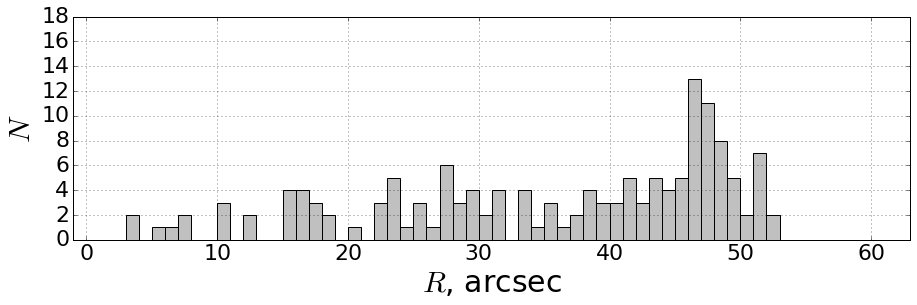

In [34]:
FB_method(fits_file='./kinematics/NGC3686_RV.fits',galname='NGC3686',step=2,width=8,dmin=1,dmax=60,cvel=1153,PA0=106,incl0=33,
                    vmax=150,free_param='VROT',width_hist=1,delta_V=12,plot_hist=True,get_values=False,plot_velocity=True)

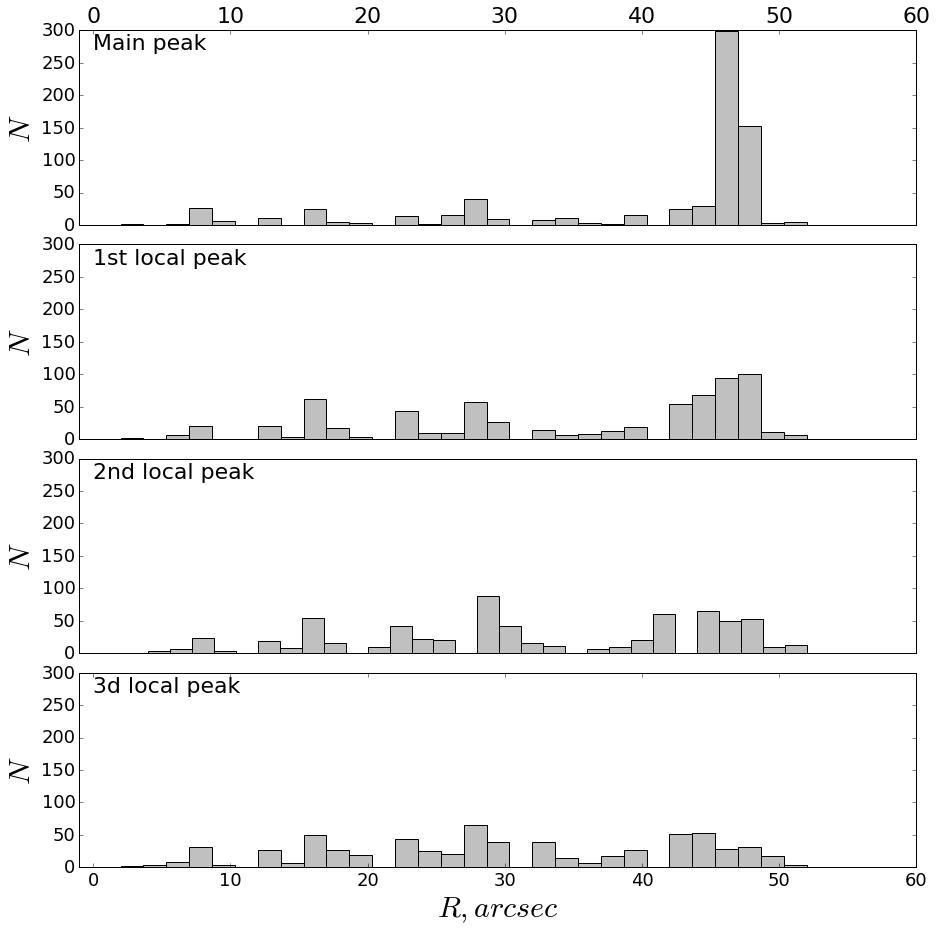

In [39]:
FB_MonteCarlo_peaks(fits_file='./kinematics/NGC3686_RV.fits',galname='NGC3686',step=3,width=8,width_err=2,ratio=2,dmin=1,
              dmax=60,cvel=1153,cvel_err=4,PA0=107,PA_err=3,incl0=34,incl_err=4,vmax=170,free_param='VROT',width_hist=2,delta_V=14,N_iter=600)

In [ ]:
dist_3686, hist_3686 = FB_MonteCarlo_sum(fits_file='./kinematics/NGC3686_RV.fits',galname='NGC3686',step=3,width=6,width_err=1,ratio=2,dmin=1,
              dmax=60,cvel=1153,cvel_err=2,PA0=107,PA_err=3,incl0=34,incl_err=2,vmax=170,free_param='VROT',width_hist=1.5,delta_V=14,N_iter=600, get_results=True)

In [ ]:
np.save('./results_images/NGC3686_MC_dist.npy',dist_3686)
np.save('./results_images/NGC3686_MC_hist.npy',hist_3686)

47.471750213791715 5.056625749506794 1.5228445268978048


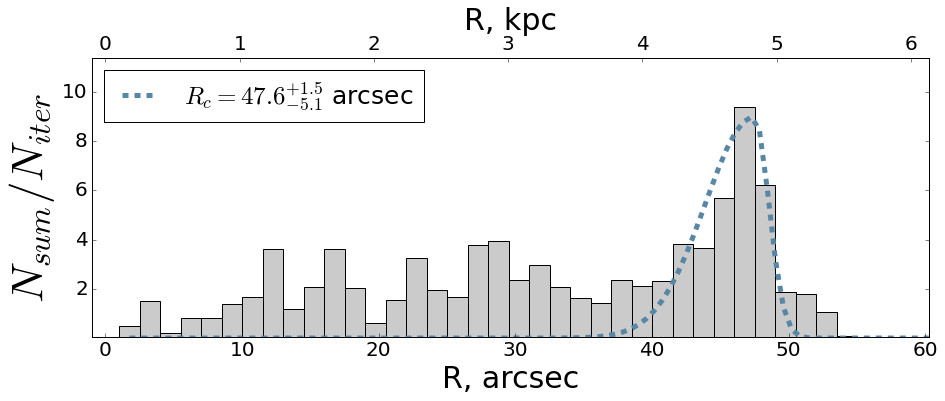

In [36]:
dist_3686 = np.load('./results_images/NGC3686_MC_dist.npy')
hist_3686 = np.load('./results_images/NGC3686_MC_hist.npy')
N_iter=600
width_hist=1.5
cont=0.2
Mpc=21
dist_points = np.linspace(dist_3686[0],dist_3686[-1],100)
params = FitGauss(dist_3686, hist_3686/N_iter-cont, num_Gauss=1, init_approx=[10,45,5,2], bounds=[[9,40,0,1],[12,50,12,10]],assym=True)
fig = plt.figure(figsize=[15,5])
plt.subplots_adjust(wspace=0.05, hspace=0.1)

gs = GridSpec(1, 6, figure=fig) 
ax = fig.add_subplot(gs[0, 0:]) 
print(params[1],params[2],params[3])

ax.bar(dist_3686,hist_3686/N_iter,width=width_hist,color='#cbcbcb')
F_Gauss = assymGauss(dist_points,params[0],params[1],params[2],params[3])
ax.plot(dist_points,F_Gauss,'--',linewidth=5,color='#5886a5',label=r'$R_c = 47.6^{+1.5}_{-5.1}$ arcsec')
ax.legend(fontsize=25,loc='upper left')
def to_new_axis(x):
    scale = np.pi / (180 * 3600) * Mpc * 10**3
    return x*scale
        
def from_new_axis(x):
    scale = np.pi / (180 * 3600) * Mpc * 10**3
    return x/scale
secax = ax.secondary_xaxis('top', functions=(to_new_axis, from_new_axis))
secax.tick_params(axis='both', which='major', labelsize=20)

plt.ylabel('$N_{sum}/N_{iter}$', fontsize=45)
plt.xlim(-1,dist_3686[-1])
plt.ylim(0.05,max(hist_3686)/N_iter+2)
plt.xlabel('R, arcsec', fontsize=30)
secax.set_xlabel('R, kpc', fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=20,top=False,labeltop=False)
plt.savefig('./results_images/NGC3686_F-B.png',transparent = False, dpi=300, bbox_inches='tight', pad_inches=0.05, facecolor='white')

### NGC4321

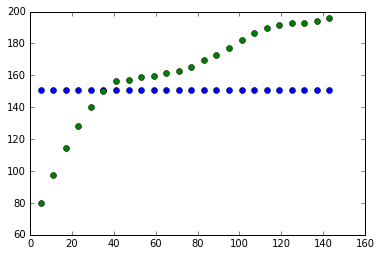

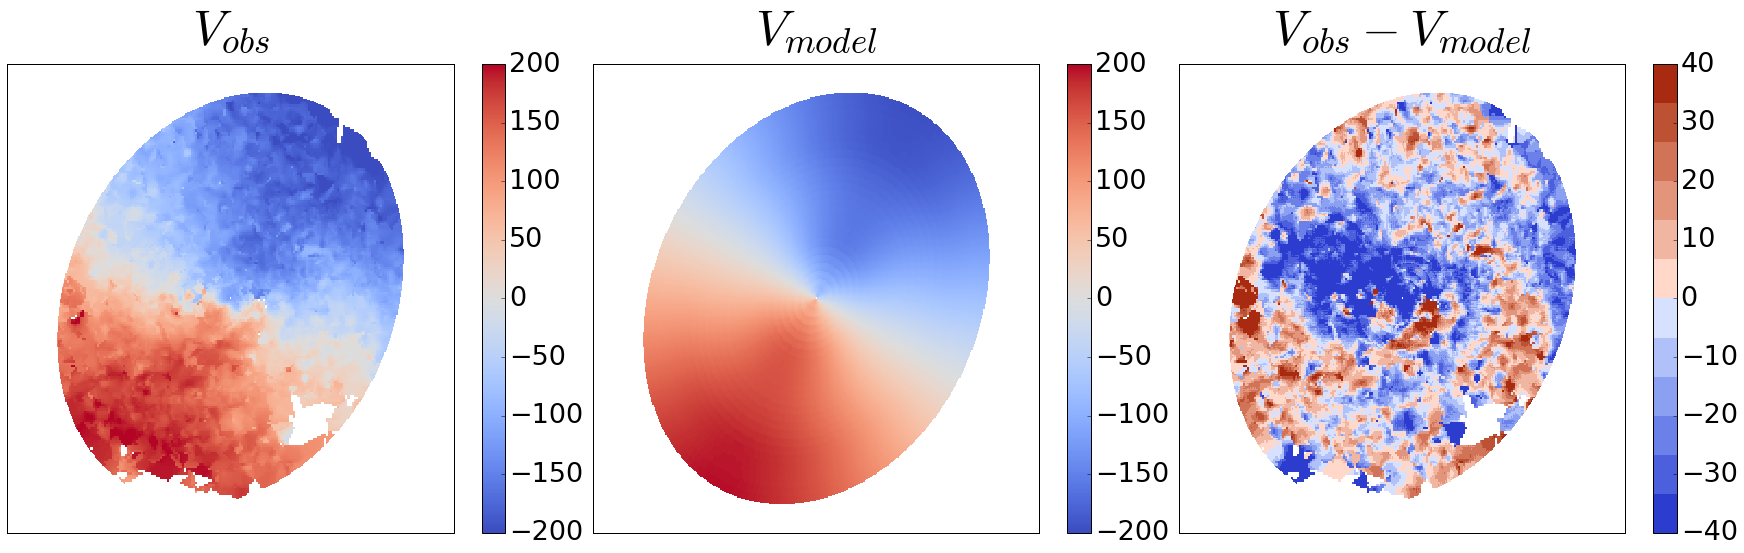

In [62]:
obtain_residuals(fits_file='./kinematics/NGC4321_RV.fits',galname='NGC4321',step=6,width=18,dmin=5,dmax=165,cvel=1560,PA0=151,incl0=38,
                    vmax=200,free_param='VROT', side='B',show_plot=True,get_residuals=False, get_velcurve=False,show_profiles=True,save_fig=True)

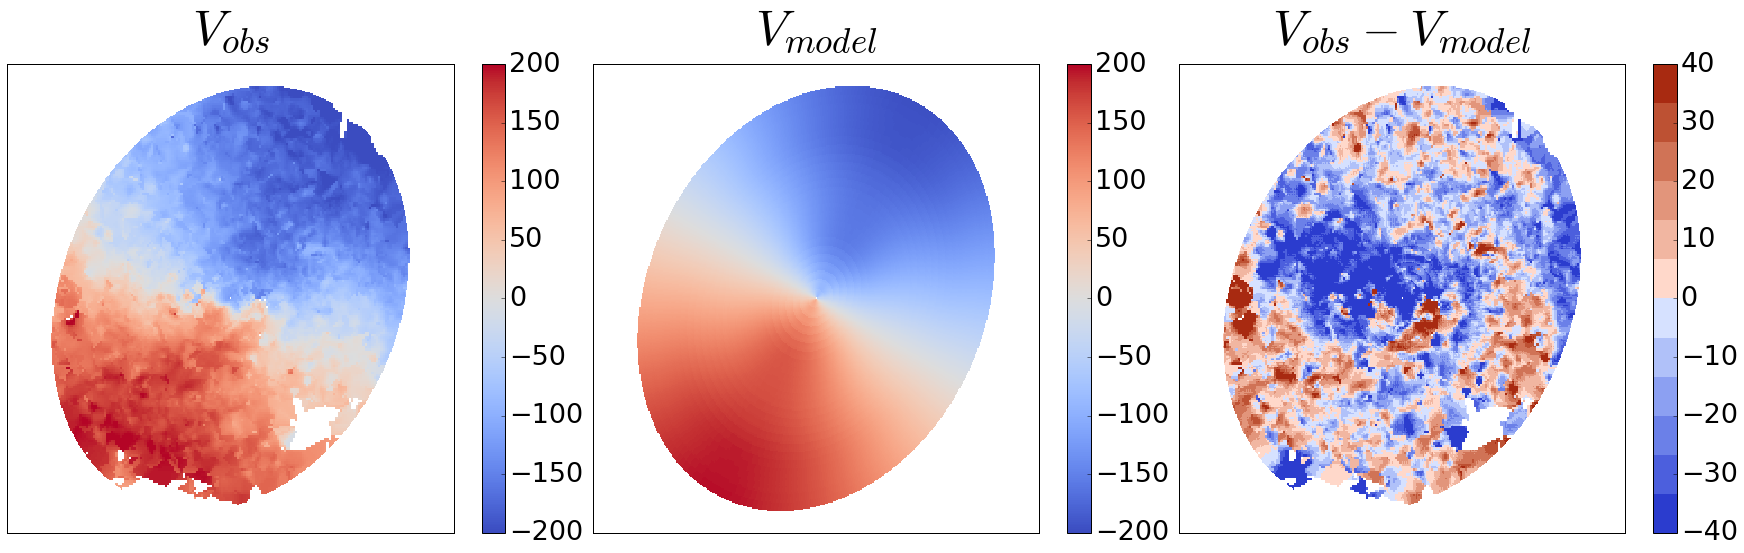

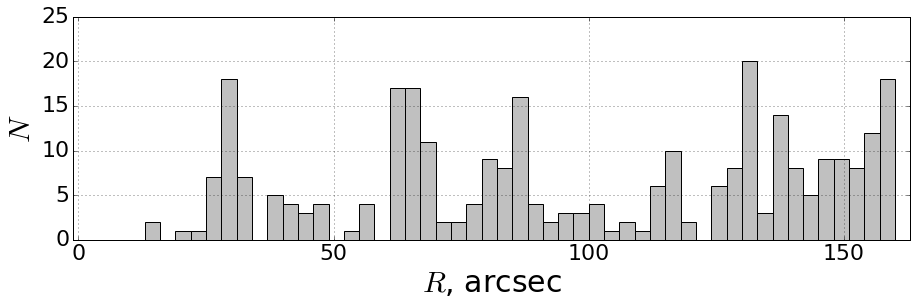

In [66]:
FB_method(fits_file='./kinematics/NGC4321_RV.fits',galname='NGC4321',step=6,width=18,dmin=5,dmax=160,cvel=1560,PA0=151,incl0=38,
                    vmax=200,free_param='VROT',width_hist=3,delta_V=13,plot_hist=True,get_values=False,plot_velocity=True)

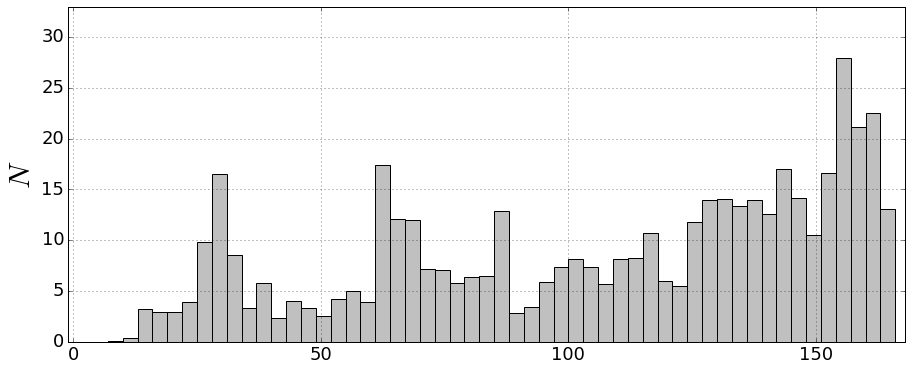

In [68]:
dist_4321, hist_4321 = FB_MonteCarlo_sum(fits_file='./kinematics/NGC4321_RV.fits',galname='NGC4321',step=6,width=20,width_err=3,ratio=3,dmin=5,
              dmax=165,cvel=1560,cvel_err=2,PA0=151,PA_err=2,incl0=37,incl_err=2,vmax=250,free_param='VROT',width_hist=3,delta_V=12,N_iter=600,get_results=True)

In [69]:
np.save('./results_images/NGC4321_MC_dist.npy',dist_4321)
np.save('./results_images/NGC4321_MC_hist.npy',hist_4321)

29.24978230987557 3.000000000008804
63.03939903353295 1.000000000062749 5.000000000000001
157.78679659176578 5.693490373598123 136.69246477381915 10.972776365862826


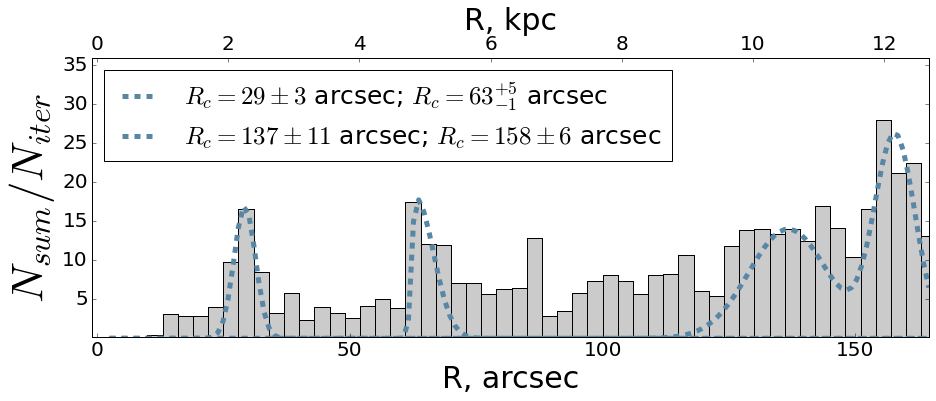

In [104]:
dist_4321 = np.load('./results_images/NGC4321_MC_dist.npy')
hist_4321 = np.load('./results_images/NGC4321_MC_hist.npy')
N_iter=600
width_hist=3
cont=5
Mpc=15.9
dist_points = np.linspace(dist_4321[0],dist_4321[-1],160)

fig = plt.figure(figsize=[15,5])
plt.subplots_adjust(wspace=0.05, hspace=0.1)

gs = GridSpec(1, 6, figure=fig) 
ax = fig.add_subplot(gs[0, 0:]) 
#########
params = FitGauss(dist_4321, hist_4321/N_iter-cont, num_Gauss=1, init_approx=[18,30,5],
                                        bounds=[[17,25,3],[20,35,10]])
print(params[1],params[2])

ax.bar(dist_4321,hist_4321/N_iter,width=width_hist,color='#cbcbcb')
F_Gauss = Gauss(dist_points,params[0],params[1],params[2])
ax.plot(dist_points,F_Gauss,'--',linewidth=5,color='#5886a5',label=r'$R_c = 29 \pm 3$ arcsec; $R_c = 63^{+5}_{-1}$ arcsec')
#########

params = FitGauss(dist_4321, hist_4321/N_iter-cont, num_Gauss=1, init_approx=[19,65,2,5],
                                        bounds=[[18,60,1,5],[25,68,10,10]],assym=True)
print(params[1],params[2],params[3])

ax.bar(dist_4321,hist_4321/N_iter,width=width_hist,color='#cbcbcb')
F_Gauss = assymGauss(dist_points,params[0],params[1],params[2],params[3])

ax.plot(dist_points,F_Gauss,'--',linewidth=5,color='#5886a5')
########
params = FitGauss(dist_4321, hist_4321/N_iter-cont, num_Gauss=2, init_approx=[27,155,5,14,140,10],
                                        bounds=[[26,150,0,14,130,7],[30,160,15,15,150,15]])
print(params[1],params[2],params[4],params[5])

ax.bar(dist_4321,hist_4321/N_iter,width=width_hist,color='#cbcbcb')
F_Gauss = DoubleGauss(dist_points,params[0],params[1],params[2],params[3],params[4],params[5])
ax.plot(dist_points,F_Gauss,'--',linewidth=5,color='#5886a5',label=r'$R_c = 137 \pm 11$ arcsec; $R_c = 158 \pm 6$ arcsec')
ax.legend(fontsize=25,loc='upper left')
def to_new_axis(x):
    scale = np.pi / (180 * 3600) * Mpc * 10**3
    return x*scale
        
def from_new_axis(x):
    scale = np.pi / (180 * 3600) * Mpc * 10**3
    return x/scale
secax = ax.secondary_xaxis('top', functions=(to_new_axis, from_new_axis))
secax.tick_params(axis='both', which='major', labelsize=20)

plt.ylabel('$N_{sum}/N_{iter}$', fontsize=45)
plt.xlim(-1,dist_4321[-1])
plt.ylim(0.2,max(hist_4321)/N_iter+8)
plt.xlabel('R, arcsec', fontsize=30)
secax.set_xlabel('R, kpc', fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=20,top=False,labeltop=False)
plt.savefig('./results_images/NGC4321_F-B.png',transparent = False, dpi=300, bbox_inches='tight', pad_inches=0.05, facecolor='white')